# Zillow Real Estate Time Series Analysis 

## 1. Business Use Case and Project Overview 

## 2. Exploratory Data Analysis and Data Preparation

### 2.1 Importing the Necessary Libraries and packages

In [1]:
# Importing the relevant packages and libraries 
import numpy as np 
import pandas as pd 
import matplotlib
import statsmodels.api as sm 
import matplotlib.pyplot as plt

### 2.2 Importing the Zillow Data as a Pandas Dataframe

In [2]:
# Importing the data from the csv 
df = pd.read_csv('Data/zillow_data.csv')

# Taking a look at the shape of the dataset
print(df.shape)

# This line will tell us if there are any rows where RegionName repeats
print(f'There are {len(df["RegionName"].value_counts())} distinct values in RegionName')

# Examining the first five rows of our dataframe
df.head()

(14723, 272)
There are 14723 distinct values in RegionName


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In an analysis process where our goal is to find the five zipcodes most ripe for investment, we had an obvious first question looking at this dataframe: which five digit number represents the zipcode? RegionID or RegionName? Some quick google searches of which County and State certain zipcodes were in told us that RegionName is the column this dataset uses to store each zipcode. We determined this from several google searches including ones like this:

<img src='Data/zipcode_example.jpg' style='width:300px;height:200px'/>

We also know from looking at the length of our value count list, that no zipcode shows up more than once, because the length of our value count list is equal to the length of our entire dataframe. 

### 2.3 Zipcodes by State

The United States has 41,692 zipcodes, and we only have 14,723 here. We wanted to find out if these zipcodes overrepresented certain regions of the country. To do this we compared the bar chart below, which tracks how many zipcodes from our dataset belong to each state, with the second chart which looks at the population of each state. 

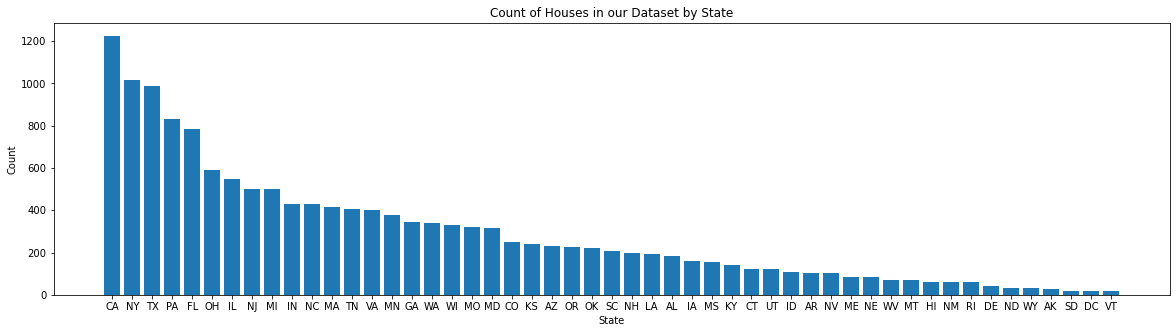

In [3]:
# Making a pandas series that lists the number of zipcodes in each state
states = df.State.value_counts()

# Visualizing the series 
fig1, ax1 = plt.subplots(figsize=(20, 5))
plt.bar(states.index, states)
plt.title('Count of Houses in our Dataset by State')
plt.xlabel('State')
plt.ylabel('Count');

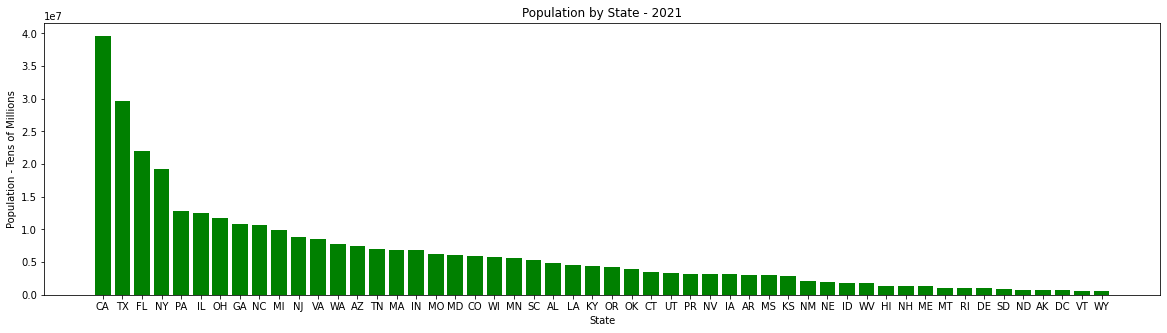

In [4]:
# This dataframe will allow us to translate state names into their two letter codes
code_df = pd.read_csv('Data/state_codes.csv', names=['State', 'Code']).dropna()

# Turning the relevant columns into a dictionary for easy use 
code_dict = dict(zip(code_df['State'], code_df['Code']))
   
# Importing the state population data from the csv we downloaded
population = pd.read_csv('Data/State Populations.csv')

# Making an ordered list of state codes to us in our bar chart 
state_codes = [code_dict[i] for i in population['State']]

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(20, 5))
plt.bar(state_codes, population['Pop'], color='green')
plt.title('Population by State - 2021')
plt.xlabel('State')
plt.ylabel('Population - Tens of Millions')
plt.show()

While some of the states rank slightly differently, the similarity between the two graphs tell us that the zipcodes in this dataset are largely representative of the population distribution of the United States. 

### 2.4 Price Distribution 

In [5]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


### 2.5 Melt Data Function 

In [12]:
# This function was provided for us with the dataset at the beginning of this project
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [13]:
df_melted = melt_data(df)

<AxesSubplot:xlabel='time'>

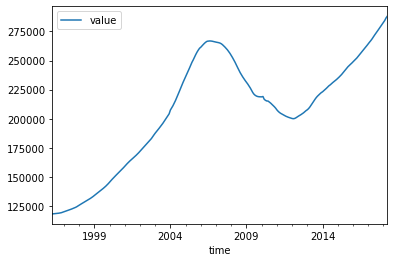

In [14]:
# Plotting the average value of all the rows as a single time series 
df_melted.plot()

In [1]:
print(len(df))

NameError: name 'df' is not defined